In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import warnings
import numpy as np
from pmdarima import auto_arima
warnings.filterwarnings('ignore')
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRegressor
import seaborn as sns
from sklearn.feature_selection import SelectFromModel

In [2]:
df = pd.read_excel("data/sales.xlsx")

df['timestamp'] = pd.to_datetime(df['transaction_date'].astype(str) + ' ' + df['transaction_time'].astype(str))

df['revenue'] = df['transaction_qty'] * df['unit_price']

df.drop(columns=['transaction_date', 'transaction_time'], inplace=True)

df.set_index('timestamp', inplace=True)

df_segmented = df.groupby(['store_location', 'product_category']) \
    .resample('D') \
    .agg({
        'revenue': 'sum',
        'transaction_qty': 'sum'
    }).reset_index()

df_segmented.head()

,store_location,product_category,timestamp,revenue,transaction_qty
0,Astoria,Bakery,2023-01-01,61.00,17
1,Astoria,Bakery,2023-01-02,127.25,36
2,Astoria,Bakery,2023-01-03,77.00,22
3,Astoria,Bakery,2023-01-04,81.50,23
4,Astoria,Bakery,2023-01-05,105.25,30


In [3]:
df_segmented['year'] = df_segmented['timestamp'].dt.year
df_segmented['month'] = df_segmented['timestamp'].dt.month
df_segmented['day'] = df_segmented['timestamp'].dt.day
df_segmented['dayofweek'] = df_segmented['timestamp'].dt.dayofweek
df_segmented['is_weekend'] = df_segmented['dayofweek'].isin([5, 6]).astype(int)
df_segmented['weekofyear'] = df_segmented['timestamp'].dt.isocalendar().week

df_segmented['revenue_lag1'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(1)
df_segmented['revenue_lag7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(7)
df_segmented['revenue_lag30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].shift(30)

df_segmented['rolling_mean_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).mean())
df_segmented['rolling_std_7'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=7).std())
df_segmented['rolling_mean_30'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].transform(lambda x: x.shift(1).rolling(window=30).mean())

df_segmented['cumulative_revenue'] = df_segmented.groupby(['store_location', 'product_category'])['revenue'].cumsum()

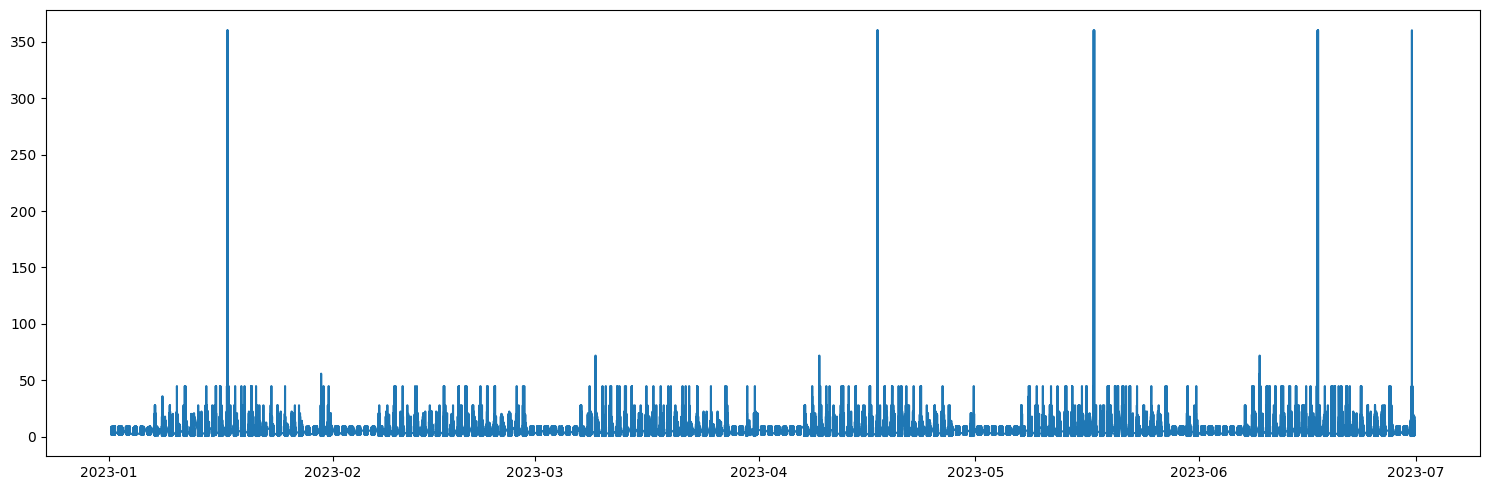

In [4]:
test_df = df_segmented[['timestamp', 'revenue']]
test_df.set_index('timestamp', inplace=True)

plt.figure(figsize=(15,5))
plt.plot(df['revenue'])
plt.tight_layout()
plt.show()

We can see in mid month there is a spike in the sales and the pattern is consistent from 2023-04

<Axes: xlabel='month', ylabel='revenue'>

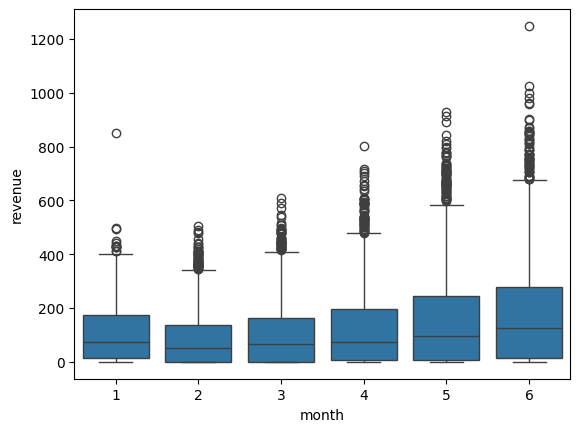

In [5]:
sns.boxplot(data=df_segmented, x='month', y='revenue')

In [6]:
df_xgb = df_segmented.copy()
df_xgb = df_xgb.sort_values(by="timestamp")
X = df_xgb.drop(columns=["timestamp", "revenue", "store_location", "product_category"])
y = df_xgb["revenue"]

# Simple holdout (e.g., last 30% for testing)
split_index = int(len(df_xgb) * 0.7)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]


In [33]:
model = XGBRegressor(n_estimators=100, random_state=42)
selector = SelectFromModel(model, threshold="median")

selector.fit(X_train, y_train)

X_train_sel = selector.transform(X_train)
X_test_sel = selector.transform(X_test)
print('Orignal training dataset shape:',X_train.shape)
print('Training set with selected features:',X_train_sel.shape)

score = XGBRegressor(n_estimator = 500, learning_rate = 0.01).fit(X_train_sel, y_train).score(X_test_sel, y_test)
print('Score:',score)

Orignal training dataset shape: (3336, 14)
Training set with selected features: (3336, 7)
Score: 0.7706150745403654


In [32]:
model_sel = XGBRegressor(n_estimator = 500, early_stopping_rounds = 10, learning_rate = 0.01)
model_sel.fit(X_train_sel, y_train, eval_set=[(X_train_sel, y_train), (X_test_sel, y_test)], verbose=50)

y_pred = model_sel.predict(X_test_sel)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"RMSE with selected features: {rmse:.2f}")

[0]	validation_0-rmse:150.53186	validation_1-rmse:248.79611
[50]	validation_0-rmse:93.34194	validation_1-rmse:163.66395
[99]	validation_0-rmse:59.32587	validation_1-rmse:114.04407
RMSE with selected features: 114.04


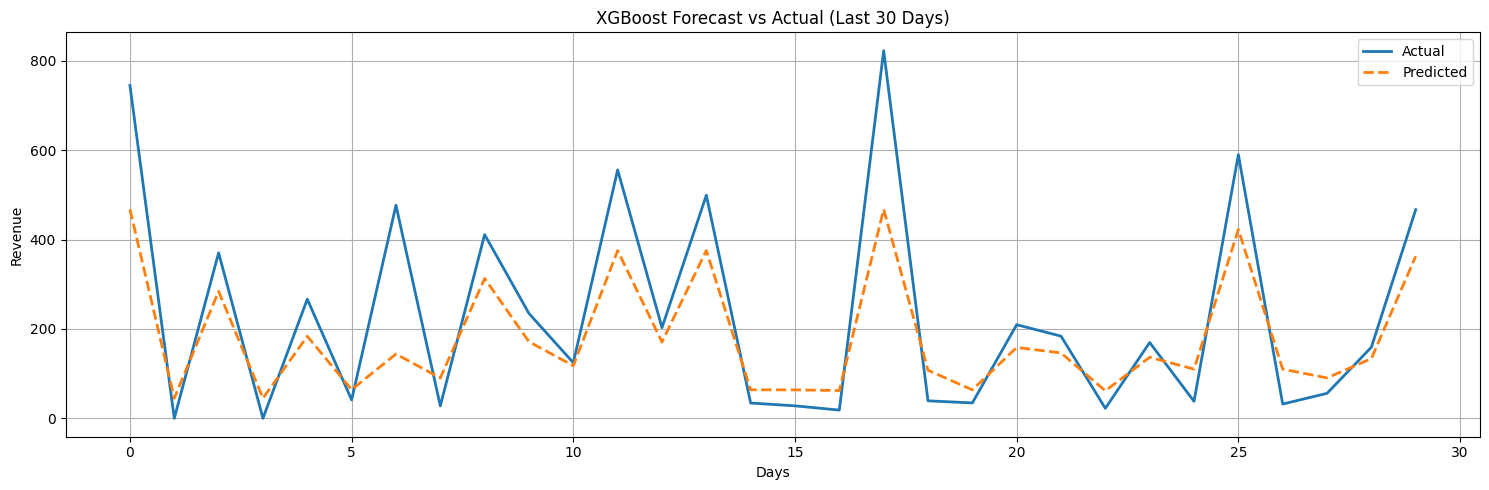

In [34]:
y_pred = model_sel.predict(X_test_sel)

N = 30
actual_series = y_test[-N:].reset_index(drop=True)
predicted_series = pd.Series(y_pred[-N:]).reset_index(drop=True)

# Plot
plt.figure(figsize=(15, 5))
plt.plot(actual_series, label="Actual", linewidth=2)
plt.plot(predicted_series, label="Predicted", linestyle="--", linewidth=2)
plt.title("XGBoost Forecast vs Actual (Last 30 Days)")
plt.xlabel("Days")
plt.ylabel("Revenue")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

_____________________________________________________________________________________________________________________

In [ ]:
# Evaluate
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Evaluation Metrics:")
print(f"MAE:  {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

Evaluation Metrics:
MAE:  77.91
RMSE: 114.04
MAPE: 3658850350672623104.00%


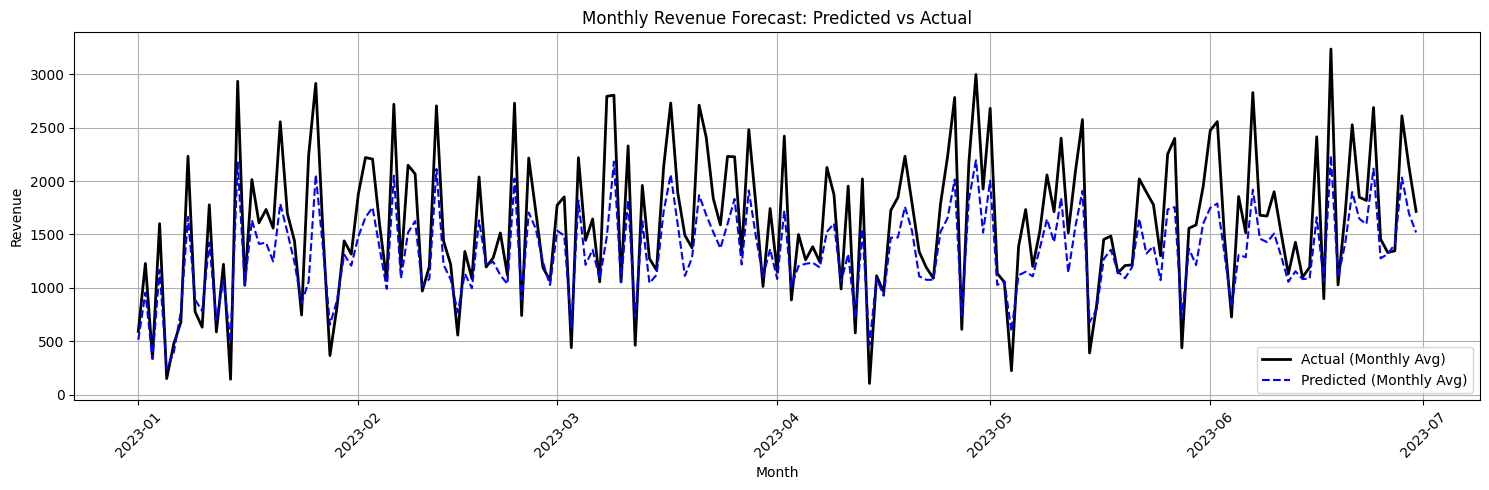

In [42]:
from sklearn.model_selection import train_test_split

timestamps = df_segmented['timestamp'].values[:]

# Now split the timestamps just like your X/y
_, timestamps_test = train_test_split(timestamps, test_size=0.3, shuffle=False)


# Step 1: Create a DataFrame for test results
results_df = pd.DataFrame({
    "timestamp": pd.to_datetime(timestamps_test),
    "actual": y_test,
    "predicted": y_pred
})

# Step 2: Set timestamp as index
results_df.set_index("timestamp", inplace=True)

# Step 3: Resample monthly (you can also use 'sum' if revenue is cumulative)
monthly_results = results_df.resample("D").sum()

# Step 4: Plot
plt.figure(figsize=(15, 5))
plt.plot(monthly_results.index, monthly_results["actual"], label="Actual (Monthly Avg)", color='black', linewidth=2)
plt.plot(monthly_results.index, monthly_results["predicted"], label="Predicted (Monthly Avg)", color='blue', linestyle='--')
plt.title("Monthly Revenue Forecast: Predicted vs Actual")
plt.xlabel("Month")
plt.ylabel("Revenue")
plt.grid(True)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

In [44]:
# Save model
model_sel.save_model('xgb_model.json')